In [54]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda:0')
print(device)

batch_size = 32
block_size = 128 
train_iters = 3000
learning_rate = 3e-4
n_embd = 384
n_head = 8

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -o text.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] 
decode = lambda l: ''.join([itos[i] for i in l]) 

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) 
train_data = data[:n]
val_data = data[n:]

def get_batch(split=None):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

print(train_data.is_cuda)
print(val_data.is_cuda)


cuda:0
False
False


In [59]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei= q @ k.transpose(-2, -1) * k.shape[-1] ** -.5
        wei = wei.masked_fill(self.tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        
        out = wei @ v
        return out
    
class MultiheadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, head_size * num_heads)
        
    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1) 
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        return self.net(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, n_embd):
        super().__init__()
        self.multihead_attention = MultiheadAttention(n_heads, n_embd//n_heads)
        self.ffwd = FeedForward(n_embd)
        
    def forward(self, x):
        x = x + self.multihead_attention(x)
        x = x + self.ffwd(x)
        return x

class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, n_embd)
        self.positional_embeddings = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential (
            TransformerBlock(n_head, n_embd),
            TransformerBlock(n_head, n_embd),
            TransformerBlock(n_head, n_embd),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, x, y=None):
        x = self.token_embeddings(x) + self.positional_embeddings(torch.arange(x.shape[-1], device=device))
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        if y is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)
        return logits, loss
    
    def generate(self, idx, max_length):
        for i in range(max_length):
            window = idx[:, -block_size:]
            window = window.to(device)
            logits, loss = self(window)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [64]:
model = GPT()
model = model.to(device)
def train_model():
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    steps = []
    losses = []
    
    for i in range(train_iters):
        optimizer.zero_grad()
        x, y = get_batch()
        preds, loss = model(x, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        steps.append(i)
        
        if i % 250 == 0:
            print(f'round {i} loss: {loss}')
    
    losses = list(map(lambda x: x.cpu().detach().numpy(), losses))
    plt.plot(steps, losses)
    
    x, y = get_batch()
    preds, loss = model(x, y)

round 0 loss: 4.620083332061768
round 250 loss: 1.9369184970855713
round 500 loss: 1.658596158027649
round 750 loss: 1.4485208988189697
round 1000 loss: 1.2846540212631226
round 1250 loss: 1.1029272079467773
round 1500 loss: 0.9116538166999817
round 1750 loss: 0.6939548254013062
round 2000 loss: 0.5450363159179688
round 2250 loss: 0.37134850025177
round 2500 loss: 0.29868292808532715
round 2750 loss: 0.25595706701278687


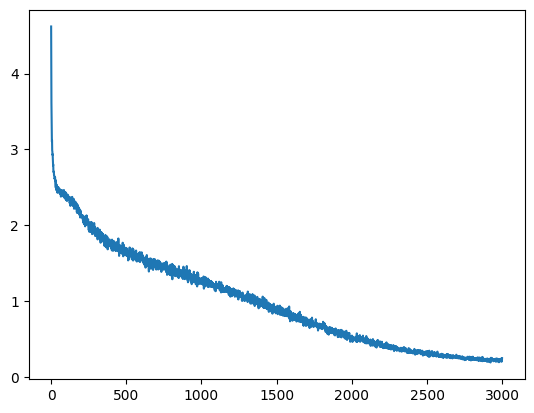

In [65]:
train_model()        

In [68]:
x, y = get_batch()
idx = x[0].view(1, -1)

preds = model.generate(idx, 512)

In [69]:
print(decode(preds[0].tolist()))

d bend
The dukedom yet unbow'd--alas, poor Milan!--
To most ignoble stooping.

MIRANDA:
O the heavens!

PROSPERO:
Mark his condition and then tale them!

ANTONIO:
Italy.

GONZALO:
Heir love! what on you thine is.

TRANIO:
Cally, go to glut it shall begin?

Boatswain:
Do you not hear.

ARIEL:
My liberty.

PROSPERO:
Ay, if thou canst, that thou wind armst.

ANTONIO:
What, us not so music in worth I odd.
And there still doth limp?
O, how is indecor: such as I live.

PETRUCHIO:
Not I, believe the prouded and me.

KATHARINA:
Now, if you love me, so fair Bianca;
Anow, I say, illone you pleasure to the table,
You may being with all closen 
